## DL project colab notebook



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/lucarezzonico/Deep_Learning

Cloning into 'Deep_Learning'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 147 (delta 62), reused 122 (delta 40), pack-reused 0
Receiving objects: 100% (147/147), 22.65 MiB | 21.74 MiB/s, done.
Resolving deltas: 100% (62/62), done.


In [3]:
%cd Deep_Learning

/content/Deep_Learning


In [4]:
import torch
from torch import nn
from torch import optim

import torchvision.transforms as transforms  # Transformations we can perform on our dataset
import matplotlib.pyplot as plt

from Miniproject_1.model import Model

# import torch.utils.data as utils
# from torchvision import datasets, transforms
# from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
# %matplotlib inline

Load Data and show some images

noisy_imgs_train_1 torch.Size([50000, 3, 32, 32]) noisy_imgs_train_2 torch.Size([50000, 3, 32, 32])
noisy_imgs_valid torch.Size([1000, 3, 32, 32]) clean_imgs_valid torch.Size([1000, 3, 32, 32])
cuda:0
epoch 1/2 training loss = 0.04
epoch 2/2 training loss = 0.03
mean psnr = 18.26 dB std psnr = 1.82 dB


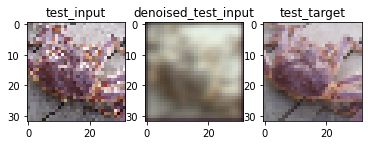

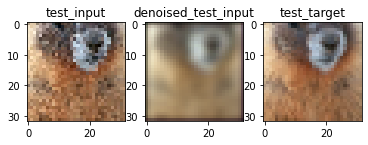

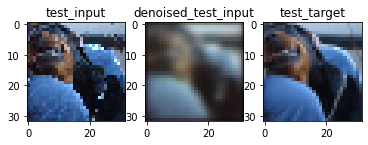

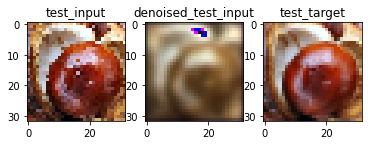

In [5]:
# Read the data from the file
noisy_imgs_train_1, noisy_imgs_train_2 = torch.load(open('/content/drive/MyDrive/Colab Notebooks/DL colabs/miniproject_dataset/train_data.pkl', 'rb'))
noisy_imgs_valid, clean_imgs_valid = torch.load(open('/content/drive/MyDrive/Colab Notebooks/DL colabs/miniproject_dataset/val_data.pkl', 'rb'))

print('noisy_imgs_train_1', noisy_imgs_train_1.size(), 'noisy_imgs_train_2', noisy_imgs_train_2.size())
print('noisy_imgs_valid', noisy_imgs_valid.size(), 'clean_imgs_valid', clean_imgs_valid.size())

def compute_psnr_mean(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).mean()

def compute_psnr_std(x, y):
    assert x.shape == y.shape and x.ndim == 4
    return - 10 * torch.log10(((x-y) ** 2).mean((1,2,3))).std()

def plot_images(*args, titles):
    for i in range(args[0].size(dim=0)): # number images to plot for each dataset
        if len(args) > 1: _, axes = plt.subplots(1, len(args))
        for img, idx in zip(args, range(len(args))): # number datasets to plot
            if len(args) > 1:
                axes[idx].imshow(img[i,:,:,:].permute((1, 2, 0)))
                axes[idx].set_title(titles[idx])
            else:
                plt.imshow(img[i, :, :, :].permute((1, 2, 0)))
                plt.title(titles[idx])
        plt.show()

# plot_images(noisy_imgs_train_1[0:4, :, :, :], noisy_imgs_train_2[0:4, :, :, :], titles=['noisy_imgs_train_1','noisy_imgs_train_2'])
# plot_images(noisy_imgs_valid[0:4, :, :, :], clean_imgs_valid[0:4, :, :, :], titles=['noisy_imgs_valid','clean_imgs_valid'])

# # transform data
# my_transforms = transforms.Compose(
#     [   # Compose makes it possible to have many transforms
#         # transforms.ToPILImage(),
#         transforms.Resize((36, 36)),  # Resizes (32,32) to (36,36)
#         transforms.RandomCrop((32, 32)),  # Takes a random (32,32) crop
#         transforms.ColorJitter(brightness=0.5),  # Change brightness of image
#         transforms.RandomRotation(degrees=45),  # Perhaps a random rotation from -45 to 45 degrees
#         transforms.RandomHorizontalFlip(p=0.5),  # Flips the image horizontally with probability 0.5
#         transforms.RandomVerticalFlip(p=0.05),  # Flips image vertically with probability 0.05
#         transforms.RandomGrayscale(p=0.2),  # Converts to grayscale with probability 0.2
#         # transforms.ToTensor(),  # Finally converts PIL image to tensor so we can train w. pytorch
#         # transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),  # Note: these values aren't optimal
#     ]
# )
#
# transformed_imgs = my_transforms(noisy_imgs_train_1[0:4, :, :, :])
# plot_images(transformed_imgs, titles=['transformed_imgs'])

################################################################################

#subset of data
train_data_upper_index = 1000
train_input = noisy_imgs_train_1[0:train_data_upper_index, :, :, :]
train_target = noisy_imgs_train_2[0:train_data_upper_index, :, :, :]
test_input = noisy_imgs_valid[0:train_data_upper_index, :, :, :]
test_target = clean_imgs_valid[0:train_data_upper_index, :, :, :]

# model = Model(lr=1e-1, optimizer='SGD', criterion='MSE', scheduler_gamma=1)
# model = Model(lr=1e-3, optimizer='Adam', criterion='MSE', scheduler_gamma=1)
# model = Model(lr=1e-3, optimizer='Adagrad', criterion='MSE', scheduler_gamma=1)
model = Model(lr=5e-1, optimizer='Adadelta', criterion='MSE', scheduler_gamma=0.8)

# train
model.train(train_input, train_target, num_epochs=2, mini_batch_size=20, lambda_l2=0)
model.save_model()

# load model
model.load_pretrained_model()

# denoise input
denoised_test_input = model.predict(test_input)
denoised_test_input = denoised_test_input.detach()

# PSNR
psnr_mean = float(compute_psnr_mean(denoised_test_input, test_target.float().div(255)))
psnr_std = abs(float(compute_psnr_std(denoised_test_input, test_target.float().div(255))))
print('mean psnr = {:.2f}'.format(psnr_mean),'dB', 'std psnr = {:.2f}'.format(psnr_std),'dB')

denoised_test_input = denoised_test_input.mul(255).to(torch.uint8)

# plot denoised image
plot_images(test_input[0:4,:,:,:], denoised_test_input[0:4,:,:,:], test_target[0:4,:,:,:], titles=['test_input','denoised_test_input','test_target'])

# mse or this loss?
# loss = 0.5 * (denoised_test_input - input).pow(2).sum() / input.size(0)


Train